In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import pandas as pd
import numpy as np 
from torch.utils.data import DataLoader, TensorDataset
from scipy.io import arff
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
torch.manual_seed(1048)
torch.cuda.manual_seed(1048)
np.random.seed(1048)

In [3]:
X, y = make_classification(n_samples=1000, n_features=60,n_classes=2, n_clusters_per_class=2, weights=[0.9, 0.1], flip_y=0.1,  shuffle=True, random_state=1048)

In [4]:
d = np.bincount(y)
print(f'0:[{d[0]}], 1:[{d[1]}]')

0:[866], 1:[134]


In [5]:
train_x, train_y = torch.from_numpy(X[:700]), torch.from_numpy(y[:700])
val_x, val_y = torch.from_numpy(X[700:]), torch.from_numpy(y[700:])

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=300, shuffle=True)

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(60, 10)
        self.l2 = nn.Linear(10,1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.01)
        self.out = nn.Sigmoid()
        
    def forward(self, data):
        x = self.relu(self.l1(data))
        x = self.dropout(x)
        x = self.l2(x)
        x = self.out(x)
        return x


In [8]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [9]:
model = MyNN().to(device)

In [10]:
epochs = 20 
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
criterion = nn.BCELoss()

In [11]:
model.train()
for e in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.float().to(device), y_batch.float().to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:02}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 01: | Loss: 0.58581 | Acc: 81.818
Epoch 02: | Loss: 0.55430 | Acc: 84.818
Epoch 03: | Loss: 0.52763 | Acc: 85.909
Epoch 04: | Loss: 0.50594 | Acc: 85.864
Epoch 05: | Loss: 0.48520 | Acc: 85.955
Epoch 06: | Loss: 0.46916 | Acc: 86.045
Epoch 07: | Loss: 0.45356 | Acc: 85.909
Epoch 08: | Loss: 0.44055 | Acc: 85.955
Epoch 09: | Loss: 0.42823 | Acc: 85.955
Epoch 10: | Loss: 0.41743 | Acc: 85.955
Epoch 11: | Loss: 0.40731 | Acc: 85.955
Epoch 12: | Loss: 0.39989 | Acc: 85.864
Epoch 13: | Loss: 0.39208 | Acc: 86.000
Epoch 14: | Loss: 0.38470 | Acc: 85.955
Epoch 15: | Loss: 0.37878 | Acc: 86.000
Epoch 16: | Loss: 0.37079 | Acc: 86.000
Epoch 17: | Loss: 0.36706 | Acc: 85.909
Epoch 18: | Loss: 0.36205 | Acc: 86.000
Epoch 19: | Loss: 0.35661 | Acc: 85.909
Epoch 20: | Loss: 0.35271 | Acc: 85.955


C:\Users\cssar\miniconda3\envs\whiskey_pt\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cssar\miniconda3\envs\whiskey_pt\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cssar\miniconda3\envs\whiskey_pt\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
    

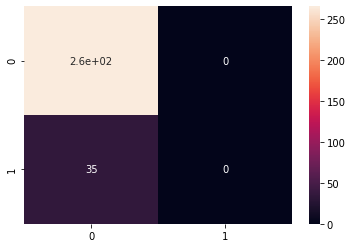

In [12]:
model.eval()
with torch.no_grad():
    for x,y in val_loader:
        x = x.float().to(device)
        y_test_pred = model(x)
        pred = torch.round(y_test_pred)
        cf_matrix = confusion_matrix(y, pred.cpu().detach().numpy())
        print(classification_report(y, pred.cpu().detach().numpy()))
        sns.heatmap(cf_matrix, annot=True)

In [16]:
torch.unique(torch.tensor([1, 1,0, 0,0,0,0,0,0,0], dtype=torch.long), return_counts=True)


(tensor([0, 1]), tensor([8, 2]))

In [20]:
torch.argmax(torch.tensor([[1,2,1],[3,2,1], [3,2,1]]), dim= 1)

tensor([1, 0, 0])

In [3]:
all_data = np.load('../data/mimic_iii/test_dump/non_iid_los_icu.npz', allow_pickle=True)
d = all_data['h_18']

In [5]:
all_data['h_18']

array([array([[-1.49922445e+00,  3.26607867e+00,  1.57458858e+00,
        -6.58933250e+00, -3.93108305e-01, -1.12306186e+00],
       [-1.17879016e+00,  3.87280113e+00, -1.40321808e+00,
        -6.58933250e+00, -4.81783866e-01, -1.79275489e+00],
       [-9.48197259e-01,  2.96977236e+00, -1.00667665e+00,
         3.90116233e-01, -1.98926841e+00, -1.33578788e+00],
       ...,
       [ 9.68419045e-01,  4.44113759e-01,  5.27118297e-01,
        -3.71969549e-02,  1.38945063e-01,  3.34505307e-01],
       [ 6.80926599e-01,  3.87674461e-01,  3.92443650e-01,
         2.47678504e-01,  3.16296186e-01,  5.23595102e-01],
       [ 7.52799711e-01,  2.18356566e-01,  1.90431679e-01,
         5.32553962e-01, -7.47810550e-01,  3.59816615e-03]]),
       array([[6.06456019],
       [1.67847222],
       [3.67291667],
       ...,
       [1.97445602],
       [2.16148148],
       [1.12420139]]),
       array([[0, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
   

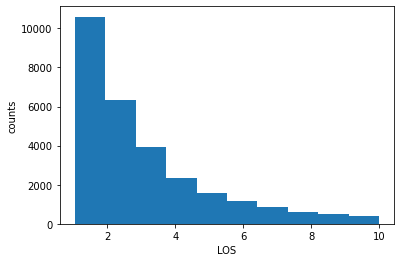

In [4]:
plt.hist(d[1])
plt.ylabel('counts')
plt.xlabel('LOS');
plt.show()